In [8]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, ENGLISH_STOP_WORDS
from sklearn.cluster import KMeans
from sklearn.decomposition import TruncatedSVD, NMF, LatentDirichletAllocation
from sklearn.preprocessing import Normalizer
from sklearn.pipeline import make_pipeline

df = pd.read_csv("roblox_cleaned.csv")
df = df.dropna(subset=["cleaned"]).copy()
df["cleaned"] = df["cleaned"].astype(str)

df.head()

,reviewId,userName,content,score,thumbsUpCount,reviewCreatedVersion,at,cleaned,sentimen
0,bfa0c0b2-0cc9-42fc-acf7-649a1fd31665,Aulia Zulfa,seru bagus,5,0,2.693.960,2025-10-10 10:56:22,seru bagus,Positif
1,0ac96058-d8d2-4fb6-a556-a147eb9fd417,Hendrik Ss,game nya Sangat seru sekali,5,0,2.693.960,2025-10-10 10:56:17,seru,Positif
2,cade0e92-c51c-48ac-8563-b65547a113f5,Revan Dwi,pls roblox jangan kamu ngelag ngelaggg,3,0,2.693.960,2025-10-10 10:56:15,lambat ngelagg,Netral
3,71a092dd-de4f-4e40-8a90-333075f3d3af,Ketut Darti,gamenya seru banget,5,0,2.693.960,2025-10-10 10:55:58,seru,Positif
4,35a243c4-f6a1-46c7-a9be-8acd46846661,Muh Taopik,lag di kurangi 😊,5,0,2.694.983,2025-10-10 10:55:36,lag,Positif


In [9]:
SLANG_MAP = {
    "ga": "tidak", "gak": "tidak", "nggak": "tidak", "gk": "tidak", "tdk": "tidak",
    "gabisa": "tidak bisa", "gbisa": "tidak bisa",
    "gasuka": "tidak suka", "gatau": "tidak tahu", "gausah": "tidak usah",
    "pls": "tolong", "plis": "tolong",
    "seruu": "seru", "baguss": "bagus",
    "ngelag": "lag"
}

def limit_repeated_chars(text: str) -> str:
    return re.sub(r"(.)\1{2,}", r"\1\1", text)

def preprocess(text: str) -> str:
    t = text.lower()
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"[@#]\w+", " ", t)
    t = limit_repeated_chars(t)
    t = re.sub(r"[^a-zA-Z\s]", " ", t)     # buang angka/punct/emoji
    t = re.sub(r"\s+", " ", t).strip()

    # slang mapping
    for k, v in sorted(SLANG_MAP.items(), key=lambda x: -len(x[0])):
        t = re.sub(rf"\b{re.escape(k)}\b", v, t)

    # buang token pendek
    toks = [w for w in t.split() if len(w) >= 3]
    return " ".join(toks)

df["text"] = df["cleaned"].apply(preprocess)
df = df[df["text"].str.strip().astype(bool)].copy()

df[["cleaned", "text"]].head(10)


,cleaned,text
0,seru bagus,seru bagus
1,seru,seru
2,lambat ngelagg,lambat ngelagg
3,seru,seru
4,lag,lag
5,login masuk update,login masuk update
6,suka,suka
7,bagus orang dewasa,bagus orang dewasa
8,wow,wow
9,bagus tidak bosan,bagus tidak bosan


In [10]:
stopwords_id = set("""
yang dan di ke dari ini itu nya untuk dengan saya aku kamu dia mereka kita kalian
ada adalah jadi karena agar jika kalau tapi namun juga lagi sudah belum sangat
banget aja saja sih deh lah kok pun nih tuh
""".split())

domain_sw = set(["roblox","game","main","map","gamenya"])

# kata pujian terlalu dominan -> bikin cluster/topik dangkal
generic_sw = set(["seru","bagus","suka","keren","mantap","senang","baik","enak"])

STOPWORDS = sorted(list(stopwords_id | domain_sw | generic_sw | set(ENGLISH_STOP_WORDS)))
len(STOPWORDS)


372

In [11]:
tfidf = TfidfVectorizer(
    stop_words=STOPWORDS,
    min_df=3,
    max_df=0.9,
    ngram_range=(1,2),
    sublinear_tf=True,
    max_features=15000
)

X = tfidf.fit_transform(df["text"])

svd = TruncatedSVD(n_components=30, random_state=42)
X_red = make_pipeline(svd, Normalizer(copy=False)).fit_transform(X)

X.shape, X_red.shape


((4318, 1444), (4318, 30))

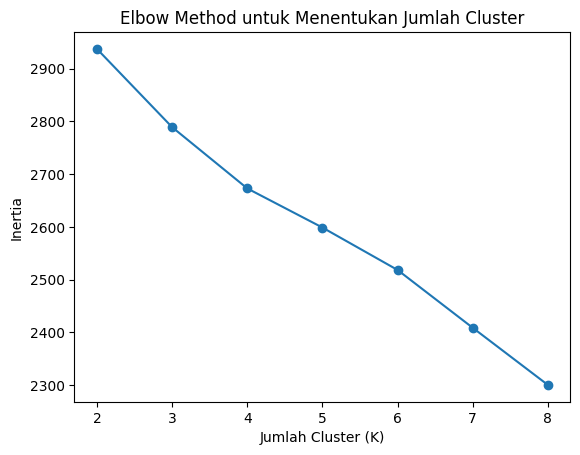

[2937.489163604716,
 2789.2242553952483,
 2673.066973958355,
 2598.9044716223884,
 2518.4877728546153,
 2408.9025722906945,
 2300.5608012875564]

In [12]:
inertia = []
K = range(2, 9)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init=10)
    km.fit(X_red)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(list(K), inertia, marker="o")
plt.xlabel("Jumlah Cluster (K)")
plt.ylabel("Inertia")
plt.title("Elbow Method untuk Menentukan Jumlah Cluster")
plt.show()

inertia


In [20]:
k_optimal = 4

kmeans = KMeans(n_clusters=k_optimal, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_red)

df["cluster"].value_counts().sort_index()


,count
cluster,
0,2373
1,884
2,465
3,596


In [21]:
terms = np.array(tfidf.get_feature_names_out())

def top_terms_per_cluster(df, X, k, topn=12):
    out = {}
    for c in range(k):
        idx = np.where(df["cluster"].to_numpy() == c)[0]
        mean_vec = X[idx].mean(axis=0)
        mean_arr = np.asarray(mean_vec).ravel()
        top_idx = mean_arr.argsort()[-topn:][::-1]
        out[c] = terms[top_idx].tolist()
    return out

tops = top_terms_per_cluster(df, X, k_optimal, topn=12)

for c in range(k_optimal):
    print(f"Cluster {c} (n={sum(df['cluster']==c)}): " + ", ".join(tops[c]))

print("\nContoh 8 review per cluster:")
for c in range(k_optimal):
    print(f"\n--- Cluster {c} ---")
    display(df[df["cluster"]==c][["cleaned", "text"]].sample(n=min(8, sum(df["cluster"]==c)), random_state=42))


Cluster 0 (n=2373): lambat, teman, update, mabar, bug, kasih, bintang, bangett, karna, orang, lag, kadang
Cluster 1 (n=884): mohon, like, pokok, pake, good, mulu, gratis, mainin, beli, upgrade, grafik, tagih
Cluster 2 (n=465): tolong, bug, tidak, hapus, sinyal, talon, tolong bug, update, akun, masuk, rusak, error
Cluster 3 (n=596): tidak, bisa, tidak bisa, masuk, akun, bosan, login, tidak bosan, jelas, tidak jelas, lambat, bug

Contoh 8 review per cluster:

--- Cluster 0 ---


,cleaned,text
1427,bagus mes banyka bug,bagus mes banyka bug
2730,bagus update rangin bagus,bagus update rangin bagus
161,bagus map mabar,bagus map mabar
3387,seru,seru
89,seruu bngtt,seru bngtt
3175,seru main,seru main
1900,zuperr superr seruu,zuperr superr seru
1076,bagus seru senang suka,bagus seru senang suka



--- Cluster 1 ---


,cleaned,text
216,parkour rambut gratis kesal mati tulis favorit,parkour rambut gratis kesal mati tulis favorit
1896,bicara ban mic,bicara ban mic
3073,tolong fix bug clothes short ava fish beli pak...,tolong fix bug clothes short ava fish beli pak...
3522,bagus bnyak bet makan data,bagus bnyak bet makan data
4290,seru evolusi fiturnya bagus evolusi capybara f...,seru evolusi fiturnya bagus evolusi capybara f...
4096,akn tudu pake citr,akn tudu pake citr
1674,ngomong dikit kena ban keren soft spoken,ngomong dikit kena ban keren soft spoken
1546,ganti pasword ribet suruh verifikasi langkah m...,ganti pasword ribet suruh verifikasi langkah m...



--- Cluster 2 ---


,cleaned,text
672,bagus masuk server orang tolong masuk server m...,bagus masuk server orang tolong masuk server m...
791,bagus tolong hapus main,bagus tolong hapus main
383,suka pilih and yap like cuman tolong hbs diupd...,suka pilih and yap like cuman tolong hbs diupd...
4273,jujurr oon mon maap yee masaa scroll tik tok b...,jujurr oon mon maap yee masaa scroll tik tok b...
2766,tolong update jelek,tolong update jelek
2181,buka layar putih,buka layar putih
2993,talon kikir,talon kikir
265,bagus tolong alami render main padahl internet...,bagus tolong alami render main padahl internet...



--- Cluster 3 ---


,cleaned,text
1440,pgi admin tidak kalau tdur ush mainin mamas sm...,pgi admin tidak kalau tdur ush mainin mamas sm...
1813,gatau bilang bagus pake,tidak tahu bilang bagus pake
3322,bagus lag stress ilang kualitas bagus tidak burik,bagus lag stress ilang kualitas bagus tidak burik
3354,suka main kls sampe skrng kls tidak rasa roblo...,suka main kls sampe skrng kls tidak rasa roblo...
1396,tidak suka player orang jawa chat party logo p...,tidak suka player orang jawa chat party logo p...
2339,tidak toleransi agama ras ibadah main main har...,tidak toleransi agama ras ibadah main main har...
749,akun gabisa pakai ganti akun perbaikin bug jelek,akun tidak bisa pakai ganti akun perbaikin bug...
2194,buruk sekali seru tidak main main teman map po...,buruk sekali seru tidak main main teman map po...


In [22]:
nmf = NMF(n_components=k_optimal, random_state=42)
W = nmf.fit_transform(X)
H = nmf.components_

print("=== Topik NMF ===")
for i, topic in enumerate(H):
    top_idx = topic.argsort()[-12:][::-1]
    print(f"Topik {i}: " + ", ".join(terms[top_idx]))

=== Topik NMF ===
Topik 0: tidak, bisa, tidak bisa, akun, masuk, tolong, login, bisa masuk, bisa login, bosan, tidak bosan, orang
Topik 1: lambat, kadang, kadang lambat, wifi, jaring, lambat lambat, sinyal, lambat wifi, dikit, lambat tidak, wifi lambat, aneh
Topik 2: bug, update, kasih, bintang, kasih bintang, tolong, lag, terima, terima kasih, tolong bug, kadang, mohon
Topik 3: teman, mabar, mabar teman, garden, grow, grow garden, bangett, teman teman, temen, pokok, orang, mabar temen


In [23]:
count_vect = CountVectorizer(
    stop_words=STOPWORDS,
    min_df=3,
    max_df=0.95
)
X_count = count_vect.fit_transform(df["text"])
lda_terms = np.array(count_vect.get_feature_names_out())

lda = LatentDirichletAllocation(
    n_components=k_optimal,
    random_state=42,
    learning_method="batch"
)
lda.fit(X_count)

print("=== Topik LDA ===")
for i, topic in enumerate(lda.components_):
    top_idx = topic.argsort()[-12:][::-1]
    print(f"Topik {i}: " + ", ".join(lda_terms[top_idx]))

=== Topik LDA ===
Topik 0: lag, tolong, bangett, pake, tower, beli, wifi, tarik, data, tombol, langsung, mainin
Topik 1: update, teman, kadang, tolong, mabar, anak, jaring, asik, lambat, mulu, temen, pokok
Topik 2: tidak, bisa, akun, masuk, tolong, update, login, bug, jelek, mohon, beli, hilang
Topik 3: tidak, kasih, bug, lambat, bintang, orang, tolong, garden, grow, mohon, terima, hapus
